In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import libraries.model   as clm
import libraries.dataset as cld
import os
import torch
import json

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._show_config()
/home/claudio/cibran/Work/UCL/ml-phasetransitions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this notebook you are able to load an use a pre-trained model for predicting the lattice contribution to the free-energy over an input database. The model, $GCNN$, predicts the lattice contribution to the free-energy, $F_v(m, T) = GCNN(m, T)$, for material $m$ at temperature $T$. Then, knowing the ground-state energy of material $m$, $E_0 (m)$ (typically estimated from DFT), the Helmholtz free-energy reads from:

\begin{equation}
    F(m, T) = E_0 (m) + F_v(m, T)
\end{equation}

Importantly, this approach disregards any other contribution to the free-energy that just vibrational (e.g., metallic materials should be avoided).

The baseline pretrained model has been trained in the 100 to 700 K temperature range, thus it is recommended to make predictions within the 200 to 600 K range, in order to avoid the misbehaviour of $C_p$ at high temperature.

We implemented a tool which allows estimating the quality of the predicted free energy regarding 1) the chemistry of the target material and 2) the temperature at which the prediction is made. This approach is valid for any other input model, as it directly checks the proximity of the hyper-representation that the GCNN creates for the target material and this from any known prediction.

Ferromagnetic transitions are estimated based on pure geometrical reasons, predicted as any transition involving a non-centrosymmmetric space group.

**Note on Performance Optimization**: When `load_properties=True` is passed to the dataset creation function, the graph generation pre-loads and stores material properties (EPA, LTC, centrosymmetry, space group, and total mass) directly in the graph objects. This eliminates redundant file I/O operations during analysis and significantly improves performance.

The input database should contain on each folder a POSCAR file with the structure, a file name EPA with the energy per atom in eV/atom (typically from DFT) and, optionally, a file name LTC with the lattice thermal conductivity in W/mK. It should be strucuture like:

**database**  
&nbsp;**material-1**  
&nbsp;&nbsp;&nbsp;**polymorph-1**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- POSCAR  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- EPA  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- LTC (opt)  
&nbsp;&nbsp;&nbsp;**polymorph-2**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- POSCAR  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- EPA  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- LTC (opt)  
&nbsp;&nbsp;&nbsp;**polymorph-...**  
&nbsp;**material-2**  
&nbsp;&nbsp;&nbsp;**polymorph-...**  
&nbsp;**material-...**  

# Define parameters

In [2]:
model_folder    = 'model'  # Pre-trained model and dataset parameters
data_folder     = 'example-data'  # Example coefficients and labels of the target database
output_folder   = 'output'  # Output files and figures
input_folder    = 'input'  # General files (e.g., atomic masses information)
target_database = '/home/claudio/cibran/Work/UCL/PhaseTransitions/Loaded_PhaseTransition'  # Target database

# Whether to plot the harmonic extrapolations of Fv (very time-consuming) or not
plot_extrapolations = False

# Defining the range of temperatures
Ti = 300
Tf = 600
dT = 50
temperatures = np.arange(Ti, Tf+dT, dT)  # Temperatures for prediction of free-energies

# Perform predictions

For the sake of optimization, we first predict all free-energies in the target database. In order to do that, we read the parameters needed for standardizing the target dataset, load the pre-trained model, perform the predictions and smooth those with a fitting to a fourth-order polynomial (with respect to temperature).

In [3]:
# Load standardization parameters
with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Load reference dataset for uncertainty estimation
reference_dataset = torch.load(f'{model_folder}/ref_dataset_std.pt', weights_only=False)

# Load and prepare model
model = clm.GCNN(features_channels=5, pdropout=0).to(device)
model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(device)))
model.eval()

# Load uncertainty data and fit interpolator
uncertainty_data = cld.load_json(f'{model_folder}/uncertainty_data.json')
interpolator = clm.fit_interpolator(uncertainty_data['uncertainty_values'], reference_dataset, model)
del reference_dataset

# Create dataset with properties loaded
dataset = cld.create_predictions_dataset(target_database)

# Process each material individually
print(f"Processing {len(dataset)} materials...")
for i, data in enumerate(dataset):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(dataset)} materials")
    
    # Make predictions and attach to data object
    clm.predict_single_material(
        data, temperatures, model, standardized_parameters, 
        uncertainty_data, interpolator
    )

print(f"Completed! Processed {len(dataset)} materials.")

Processing 49313 materials...
  Processed 10/49313 materials


/home/claudio/cibran/Work/UCL/ml-phasetransitions/libraries/model.py:291: OptimizeWarning: Covariance of the parameters could not be estimated
  _beta_, _s_beta_ = curve_fit(Helmholtz_free_energy_function,


  Processed 20/49313 materials
  Processed 30/49313 materials
  Processed 40/49313 materials
  Processed 50/49313 materials
  Processed 60/49313 materials
  Processed 70/49313 materials
  Processed 80/49313 materials
  Processed 90/49313 materials
  Processed 100/49313 materials
  Processed 110/49313 materials
  Processed 120/49313 materials
  Processed 130/49313 materials
  Processed 140/49313 materials
  Processed 150/49313 materials
  Processed 160/49313 materials
  Processed 170/49313 materials
  Processed 180/49313 materials
  Processed 190/49313 materials
  Processed 200/49313 materials
  Processed 210/49313 materials
  Processed 220/49313 materials
  Processed 230/49313 materials
  Processed 240/49313 materials
  Processed 250/49313 materials
  Processed 260/49313 materials
  Processed 270/49313 materials
  Processed 280/49313 materials
  Processed 290/49313 materials
  Processed 300/49313 materials
  Processed 310/49313 materials
  Processed 320/49313 materials
  Processed 330/

# Compute phase transitions

Then, we have already computed the free-energies for each material in the intended temperature range and also the parameters of the fourth-order polynomial which smooths the predictions. With that information, we can look for phase transitions for each materials presenting at least two polymorphs in the target dataset and, for those, extract transition temperature, entropy change or whether this is or not a ferroelectric transition.

In [4]:
# Group polymorphs by compound without sorting (keeps original dataset order)
compound_groups = {}
for data in dataset:
    compound, polymorph = data.label.split()
    compound_groups.setdefault(compound, []).append(data)

# Ordered list of compounds (in dataset order)
unique_compounds = list(compound_groups.keys())

In [30]:
# Initializing files with data
stable_transition_phases     = []
metastable_transition_phases = []
for compound in unique_compounds:
    polymorphs_data = compound_groups[compound]
    n_polymorphs = len(polymorphs_data)

    if n_polymorphs > 1:
        print(compound)

        for k in range(n_polymorphs):
            data_k = polymorphs_data[k]

            # Plotting
            if plot_extrapolations:
                temperatures_plot = np.arange(Ti, Tf+dT, 0.1)
                gibbs_energy_plot = data_k.gs_energy + clm.Helmholtz_free_energy_function(temperatures_plot, *data_k.coefficients)
                plt.plot(temperatures_plot, gibbs_energy_plot, label=data_k.space_group)

            # Looking for phase transitions
            for m in np.arange(k+1, n_polymorphs):
                data_m = polymorphs_data[m]

                # Computing the entropy change provoked by the transition
                d_E0 = data_m.gs_energy - data_k.gs_energy
                d_alpha, d_beta, d_gamma = (data_m.coefficients.T - data_k.coefficients.T)[0]

                # We scaled parameters for fitting, so now we re-scale them
                d_beta  *= 1e-5
                d_gamma *= 1e-10

                # Two possible transition temperatures
                temp_root_1 = (-d_beta + np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
                temp_root_2 = (-d_beta - np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)

                # Filter valid transition within the temperature range of interest
                c_valid_temperatures = [x for x in [np.sqrt(temp_root_1), np.sqrt(temp_root_2)] if Ti < x < Tf]

                # Determine if there is any transition within the temperature interval
                if not len(c_valid_temperatures):
                    continue
                elif len(c_valid_temperatures) > 1:
                    print(f'Warning: {len(c_valid_temperatures)} transitions within this interval')

                # Get the expected critical temperature and free energy
                c_temperature = np.min(c_valid_temperatures)

                # Compute free energy and slope changes
                c_free_energy = data_k.gs_energy + clm.Helmholtz_free_energy_function(c_temperature, *data_k.coefficients)
                d_slope       = c_temperature * np.abs(2 * d_beta + 4 * d_gamma * c_temperature**2)

                # Compute entropy change using stored mass per atom, from meV/atomK to J/kgK (1e3 from g to kg)
                c_entropy = d_slope * 6.022 * 1.6 * 1e4 / data_k.mass_per_atom if data_k.mass_per_atom else np.nan

                # Get uncertainties ML
                c_temp_idx = np.argmin(np.abs(temperatures-c_temperature))
                uncert_1 = data_k.uncertainties[c_temp_idx]
                uncert_2 = data_m.uncertainties[c_temp_idx]
                uncert_Fv_ML = np.sqrt(uncert_1**2 + uncert_2**2)
                uncert_ML = clm.compute_transition_temperature_uncertainty(
                    d_E0, d_alpha, d_beta, d_gamma, uncert_Fv_ML, c_temperature
                )

                # Get uncertainties DFT
                uncert_Fv_DFT = np.sqrt(2) * 4  # sqrt(4² + 4²) meV/atom
                uncert_DFT = clm.compute_transition_temperature_uncertainty(
                    d_E0, d_alpha, d_beta, d_gamma, uncert_Fv_DFT, c_temperature
                )

                # Check which has lower energy at lower temperature
                c_free_energy_1 = data_k.gs_energy + clm.Helmholtz_free_energy_function(c_temperature-5, *data_k.coefficients)
                c_free_energy_2 = data_m.gs_energy + clm.Helmholtz_free_energy_function(c_temperature-5, *data_m.coefficients)

                first_polymorph, last_polymorph = (data_k.space_group,  data_m.space_group)  if c_free_energy_1 < c_free_energy_2 else (data_m.space_group,  data_k.space_group)
                first_LTC,       last_LTC       = (data_k.conductivity, data_m.conductivity) if c_free_energy_1 < c_free_energy_2 else (data_m.conductivity, data_k.conductivity)
                first_label,     last_label     = (data_k.label,        data_m.label)        if c_free_energy_1 < c_free_energy_2 else (data_m.label,        data_k.label)
                label = f'{first_polymorph} -> {last_polymorph} ({c_temperature:.2f}K, {c_entropy:.2f} J/kgK)'
                print(label)

                if plot_extrapolations:
                    plt.plot(c_temperature, c_free_energy, 'o', label=label)

                # 0, 1, 2 if none, one or both are centrosymmetric, respectively
                centrosymmetric = data_k.centrosymmetry + data_m.centrosymmetry

                # Get lattice thermal conductivity change
                # Only calculate if both LTC values are valid (not NaN)
                LTC_change = None
                if centrosymmetric == 1 and not (np.isnan(first_LTC) or np.isnan(last_LTC)):
                    if first_LTC != 0:  # Avoid division by zero
                        LTC_change = (last_LTC - first_LTC) / first_LTC

                # Append information
                transition_data = {'compound': compound, 'polymorph-1': first_polymorph, 'polymorph-2': last_polymorph,
                                   'transition-temperature': c_temperature, 'entropy-change': c_entropy,
                                   'centrosymmetry': centrosymmetric, 'conductivity-change': LTC_change,
                                   'LTC-1': first_LTC, 'LTC-2': last_LTC,
                                   'uncert-ML': uncert_ML, 'uncert-DFT': uncert_DFT,
                                   'label-1': first_label, 'label-2': last_label}

                min_vib_energy = min(
                    data_j.gs_energy + clm.Helmholtz_free_energy_function(c_temperature, *data_j.coefficients)
                    for data_j in polymorphs_data
                )

                if np.isclose(c_free_energy, min_vib_energy, rtol=1e-6, atol=1e-3):
                    stable_transition_phases.append(transition_data)
                else:
                    metastable_transition_phases.append(transition_data)

        if plot_extrapolations:
            plt.title(compound)
            plt.xlabel('$T$ (K)')
            plt.ylabel(r'$F_{v}$ (meV/atom)')
            plt.legend(loc=(1.05, 0.5))
            plt.savefig(f'{output_folder}/{compound}.pdf', dpi=50, bbox_inches='tight')
            plt.show()

CdSO4
Li2Mn2CoO6
MgTiMn3O8
CsAgCl2
Li3Mn(PO4)2
P2_1/c -> P2_1 (538.54K, 51.80 J/kgK)
ZnCrO4
CoH15N6(ClO)2
Cc -> P-1 (411.78K, 130.76 J/kgK)
Ca(WO2)2
Ba4Ta2O9
LiCo6(OF5)2
Ba2BiSbO6
Al2HgS4
Sr2LaMn2O7
Cs3LaBr6
K2Mn2Be3F12
LiTaO3
Sr2MgCrO4
H2
I4/mmm -> P2_1/c (328.07K, 6930.09 J/kgK)
I4/mmm -> Cmcm (566.21K, 19877.01 J/kgK)
SrAlF5
P2_1/c -> I4 (570.75K, 95.94 J/kgK)
GePb3O5
LiVSiCO7
Ba4Zn4B14Pb2O31
Sr2NdBiO6
Na3GdV2O8
Li4Ti3V3(FeO8)2
Ti3Fe9O16
K2NaNb(OF2)2
Ba2LiTbSnO6
KCaCeNbO6
Li3V(BO3)2
Ti(PO3)4
Li2V3O6
P1 -> P1 (374.08K, 59.84 J/kgK)
P1 -> C2 (551.03K, 8.89 J/kgK)
Sr2VMoO6
Li2Nb4O11
BCl
LiMnB2O5
VZnBiO5
La2Mn(SeO)2
Li2TiMn2O6
MgV2(H2O3)2
Li5FeOF5
P3_1 -> P1 (331.82K, 53.80 J/kgK)
MgTiO3
Sr(AlS2)2
Cccm -> Fddd (405.93K, 22.38 J/kgK)
TiSnO4
LiIn(MoO4)2
Sr2HfMgCrO6
CaV2O4
Li2Fe2Si3O10
Li6MnV3(PO4)6
Ba2LaMgBiO6
Li4V2OF7
Li4V3Cr3(FeO8)2
LiMn2(CO3)4
Li2AlCoO4
Pnma -> P2_1/c (424.69K, 21.04 J/kgK)
Pna2_1 -> Pmn2_1 (321.24K, 30.01 J/kgK)
Li3Cr(BO3)2
Al8SiO14
Sr3UO6
Ag10Te4Br3
Cmcm -> Cmc2_1 (3

/tmp/ipykernel_3159361/4214663449.py:33: RuntimeWarning: invalid value encountered in sqrt
  temp_root_1 = (-d_beta + np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
/tmp/ipykernel_3159361/4214663449.py:34: RuntimeWarning: invalid value encountered in sqrt
  temp_root_2 = (-d_beta - np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha) * d_gamma)) / (2 * d_gamma)
/tmp/ipykernel_3159361/4214663449.py:37: RuntimeWarning: invalid value encountered in sqrt
  c_valid_temperatures = [x for x in [np.sqrt(temp_root_1), np.sqrt(temp_root_2)] if Ti < x < Tf]
/home/claudio/cibran/Work/UCL/ml-phasetransitions/libraries/model.py:230: RuntimeWarning: invalid value encountered in sqrt
  [x for x in [np.sqrt(root_1_n), np.sqrt(root_2_n), np.sqrt(root_1_p), np.sqrt(root_2_p)] if x >= 0]
/home/claudio/cibran/Work/UCL/ml-phasetransitions/libraries/model.py:221: RuntimeWarning: invalid value encountered in sqrt
  root_1_n = (-d_beta + np.sqrt(d_beta**2 - 4 * (d_E0 + d_alpha - uncert_Fv) * d_gamma)

# Visualize the results

In [31]:
# Convert to panda data-frames for easy handling
stable_transition_phases     = pd.DataFrame(stable_transition_phases)
metastable_transition_phases = pd.DataFrame(metastable_transition_phases)

In [32]:
stable_transition_phases_low_uncert     = stable_transition_phases[stable_transition_phases['uncert-ML']         < 200]
metastable_transition_phases_low_uncert = metastable_transition_phases[metastable_transition_phases['uncert-ML'] < 200]

## First N stable materials highest entropy changes

In [33]:
# Save to excel
df_es_stp = stable_transition_phases_low_uncert.sort_values(by='entropy-change', ascending=False)
df_es_stp.to_excel(f'{output_folder}/high-entropy stable transitions.xlsx')
df_es_stp

,compound,polymorph-1,polymorph-2,transition-temperature,entropy-change,centrosymmetry,conductivity-change,LTC-1,LTC-2,uncert-ML,uncert-DFT,label-1,label-2
119,C,R-3m,P6_3/mmc,594.721144,3188.984904,2,NaN,NaN,NaN,62.488173,13.744908,C R-3m,C P6_3-mmc
273,BHO2,P-43n,P2_1/c,370.650552,985.596964,1,NaN,NaN,NaN,99.127478,49.072207,BHO2 P-43n,BHO2 P2_1-c
561,AsH6NO4,I-42d,P2_12_12_1,447.587263,724.878480,0,NaN,NaN,NaN,162.811054,53.554031,AsH6NO4 I-42d,AsH6NO4 P2_12_12_1
523,LuH9C5(NO4)2,C222_1,C2,535.636847,677.815650,0,NaN,NaN,NaN,124.198562,44.094264,LuH9C5(NO4)2 C222_1,LuH9C5(NO4)2 C2
188,DyH9C5(NO4)2,C222_1,C2,572.723169,633.052289,0,NaN,NaN,NaN,139.693195,48.803618,DyH9C5(NO4)2 C222_1,DyH9C5(NO4)2 C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,Pb3O4,Pbam,P4_2/mbc,554.253898,57.911547,2,NaN,NaN,NaN,125.738425,71.085361,Pb3O4 Pbam,Pb3O4 P4_2-mbc
38,TbCuSe2,P2_1/c,P3m1,528.565703,55.313807,1,NaN,NaN,NaN,155.827286,95.067687,TbCuSe2 P2_1-c,TbCuSe2 P3m1
136,Hg,I-43m,P4_132,568.725062,46.254838,0,NaN,NaN,1.050482,146.754060,55.988834,Hg I-43m,Hg P4_132
73,KBaGdWO6,F-43m,Pnnn,319.664604,44.783314,1,NaN,NaN,NaN,197.161400,158.890079,KBaGdWO6 F-43m,KBaGdWO6 Pnnn


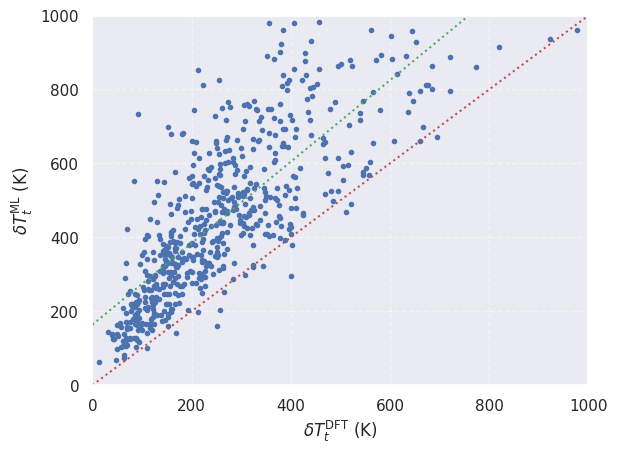

In [30]:
mask = stable_transition_phases['uncert-ML'] < 990
uncert_DFT = stable_transition_phases['uncert-DFT'][mask]
uncert_ML  = stable_transition_phases['uncert-ML'][mask]

a, b = np.polyfit(uncert_DFT, uncert_ML, 1)

plt.plot(uncert_DFT, uncert_ML, '.')
plt.xlabel(r"$\delta T_t^{\mathrm{DFT}}$ (K)")
plt.ylabel(r"$\delta T_t^{\mathrm{ML}}$ (K)")
_min_ = 0
_max_ = 1000
plt.plot([_min_, _max_], [_min_, _max_], ':r')
plt.plot([_min_, _max_], [a * _min_ + b, a * _max_ + b], ':g')
plt.xlim(_min_, _max_)
plt.ylim(_min_, _max_)
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig('ML-vs-DFT-uncert.pdf', dpi=50, bbox_inches='tight')
plt.show()

In [31]:
# Save to excel
df_es_unstp = metastable_transition_phases_low_uncert.sort_values(by='entropy-change', ascending=False)
df_es_unstp.to_excel(f'{output_folder}/high-entropy metastable transitions.xlsx')
df_es_unstp

,compound,polymorph-1,polymorph-2,transition-temperature,entropy-change,centrosymmetry,conductivity-change,LTC-1,LTC-2,uncert-ML,uncert-DFT
128,C,Fd-3m,P6_3/mmc,591.559495,3441.184739,2,NaN,NaN,NaN,58.491319,12.743531
129,C,Pa-3,Fm-3,568.766959,1118.347772,2,NaN,NaN,NaN,163.816753,37.340707
342,H2CO,I4_1/a,Pbcn,367.016143,1066.267558,2,NaN,NaN,NaN,168.810993,62.735119
130,C,Pnnm,Fm-3,592.037517,980.389527,2,NaN,NaN,NaN,170.051691,41.801004
132,C3N4,I-43d,P-43m,371.440378,821.317018,0,NaN,NaN,NaN,130.177429,43.997602
...,...,...,...,...,...,...,...,...,...,...,...
74,BaCaI4,Pbcn,I4_1/a,599.022907,60.433642,2,NaN,NaN,NaN,132.201400,74.377517
59,Ba2SrI6,P-31m,C2/c,500.030820,55.060026,2,NaN,NaN,NaN,196.814991,73.833540
71,BaCaI4,C2/c,I4_1/a,505.344390,46.920861,2,NaN,NaN,NaN,184.469311,93.158233
72,BaCaI4,Cmc2_1,Pnna,475.637073,41.666095,1,NaN,NaN,NaN,145.720765,103.348539


## Amount of phase transitions at each temperature interval

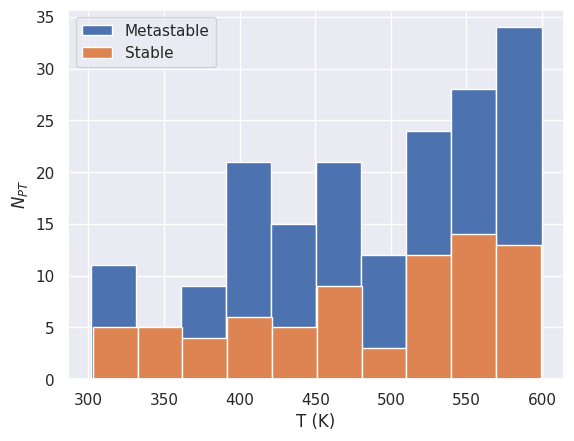

In [47]:
n, bins, patches = plt.hist(metastable_transition_phases_low_uncert['transition-temperature'], label='Metastable')
n, bins, patches = plt.hist(stable_transition_phases_low_uncert['transition-temperature'],     label='Stable')

plt.legend(loc='best')
plt.xlabel('T (K)')
plt.ylabel(r'$N_{PT}$')
plt.savefig(f'{output_folder}/histogram_critical_temperatures.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions involving some entropy change

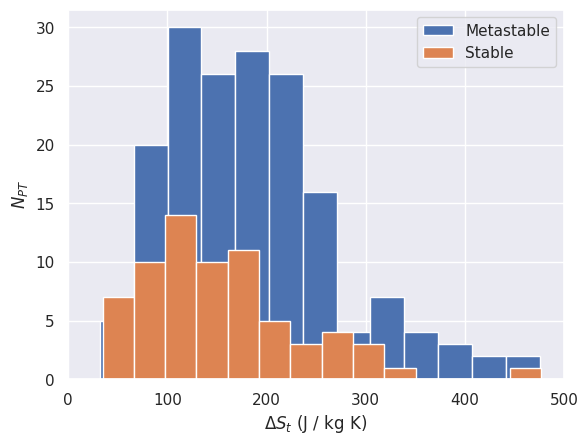

In [45]:
n, bins, patches = plt.hist(metastable_transition_phases_low_uncert['entropy-change'], bins=100, label='Metastable')
n, bins, patches = plt.hist(stable_transition_phases_low_uncert['entropy-change'],   bins=100,   label='Stable')

plt.legend(loc='best')
plt.xlim(0, 500)
plt.xlabel(r'$\Delta S_t$ (J / kg K)')
plt.ylabel(r'$N_{PT}$')
plt.savefig(f'{output_folder}/histogram_entropy_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions in terms of centrosymmetry

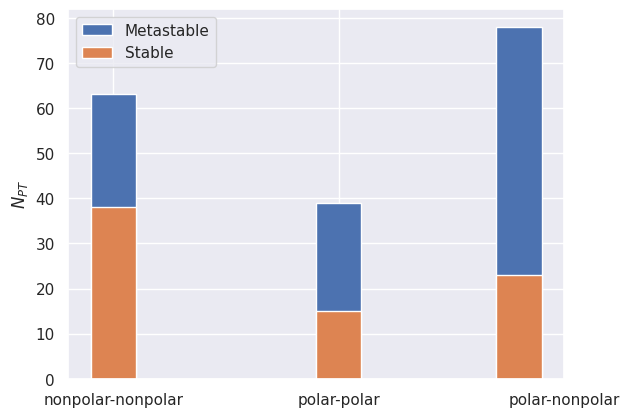

In [44]:
# Swith to type of transition
plt_metastable_non_centrosymmetry = np.array(metastable_transition_phases_low_uncert['centrosymmetry'], dtype=object)
plt_stable_non_centrosymmetry     = np.array(stable_transition_phases_low_uncert['centrosymmetry'],   dtype=object)

centrosymmetries = np.array(['polar-polar', 'polar-nonpolar', 'nonpolar-nonpolar'])

for i in range(len(centrosymmetries)):
    plt_metastable_non_centrosymmetry[np.where(metastable_transition_phases_low_uncert['centrosymmetry'] == i)[0]] = centrosymmetries[i]
    plt_stable_non_centrosymmetry[np.where(stable_transition_phases_low_uncert['centrosymmetry']         == i)[0]] = centrosymmetries[i]

# Create the histogram

n, bins, patches = plt.hist(plt_metastable_non_centrosymmetry, label='Metastable', align='left')
n, bins, patches = plt.hist(plt_stable_non_centrosymmetry,     label='Stable', align='left')

plt.ylabel(r'$N_{PT}$')
plt.legend(loc='best')
plt.savefig(f'{output_folder}/histogram_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and LTC change

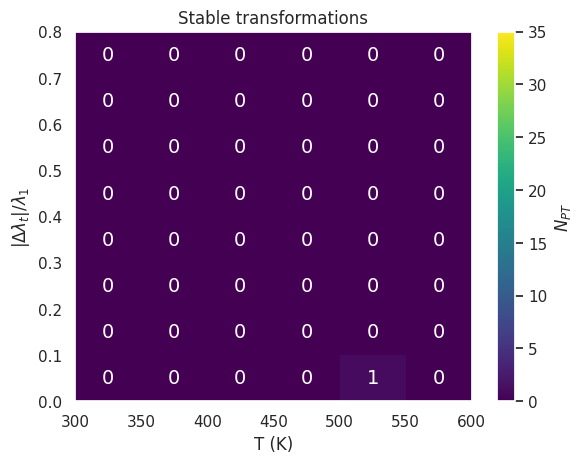

In [35]:
x_edges = temperatures
y_edges = np.linspace(0, 0.8, 8+1)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases_low_uncert['transition-temperature'],
                              np.abs(stable_transition_phases_low_uncert['conductivity-change']),
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=35)
plt.xlabel('T (K)')
plt.ylabel(r'$|\Delta \lambda_t| / \lambda_1$')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/temperature_vs_stable_conductivity_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and entropy change

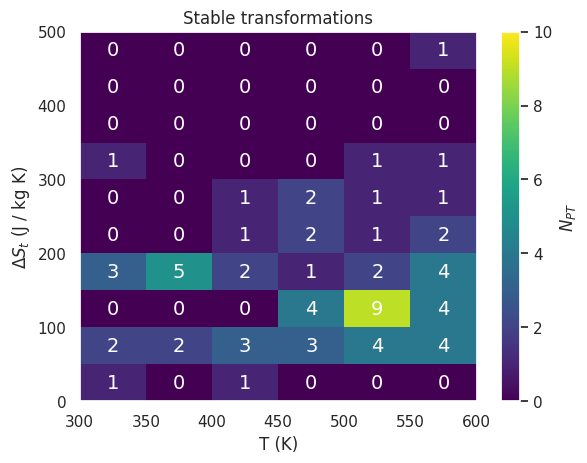

In [36]:
x_edges = temperatures
y_edges = np.linspace(0, 500, 10+1)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases_low_uncert['transition-temperature'],
                              stable_transition_phases_low_uncert['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=10)
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta S_t$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/temperature_vs_stable_entropy_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

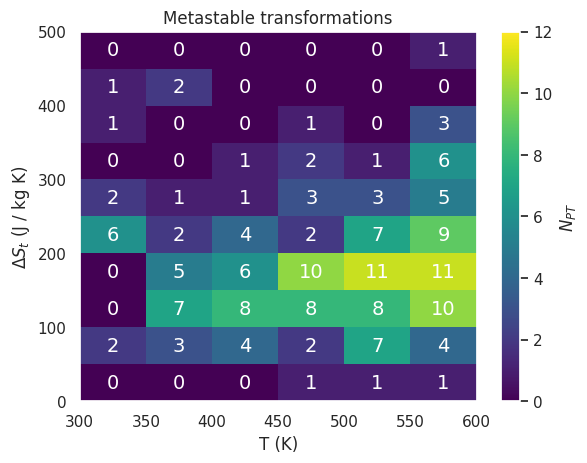

In [37]:
x_edges = temperatures
y_edges = np.linspace(0, 500, 10+1)

# Generate the 2D histogram data
distribution = np.histogram2d(metastable_transition_phases_low_uncert['transition-temperature'],
                              metastable_transition_phases_low_uncert['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=12)
plt.xlabel('T (K)')
plt.ylabel(r'$\Delta S_t$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transformations')
plt.savefig(f'{output_folder}/temperature_vs_metastable_stable_entropy_changes.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions at each temperature and centrosymmetries

In [38]:
# Create a mapping of strings to unique integers
centrosymmetries_dict = {'polar-polar':       0,
                         'polar-nonpolar':    1,
                         'nonpolar-nonpolar': 2}
centrosymmetry_edges = [0, 0.66, 1.33, 2]
centrosymmetry_ticks_x = [0.33, 1, 1.66]
centrosymmetry_ticks_labels = ['polar-polar', 'polar-nonpolar', 'nonpolar-nonpolar']

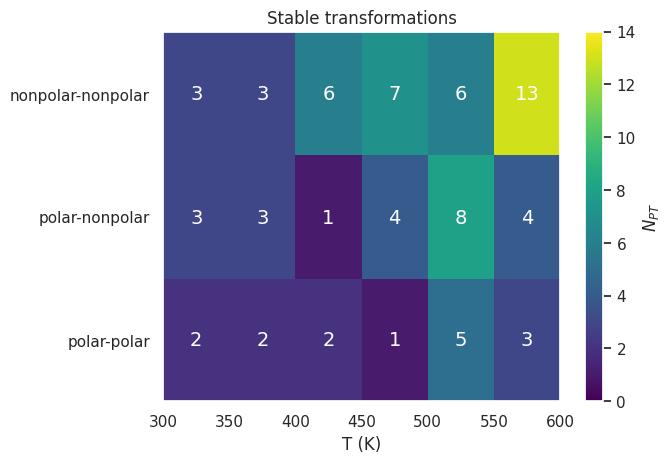

In [39]:
x_edges = temperatures
y_edges = np.array(centrosymmetry_edges)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases_low_uncert['transition-temperature'],
                              stable_transition_phases_low_uncert['centrosymmetry'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=14)
plt.yticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.xlabel('T (K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/temperature_vs_stable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

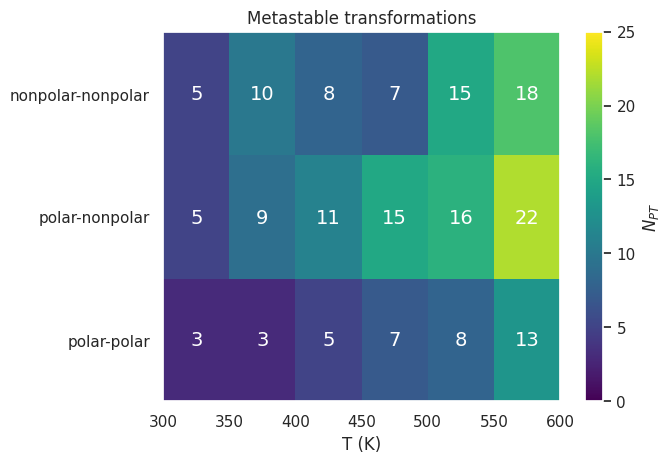

In [40]:
x_edges = temperatures
y_edges = np.array(centrosymmetry_edges)

# Generate the 2D histogram data
distribution = np.histogram2d(metastable_transition_phases_low_uncert['transition-temperature'],
                              metastable_transition_phases_low_uncert['centrosymmetry'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=25)
plt.yticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.xlabel('T (K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transformations')
plt.savefig(f'{output_folder}/temperature_vs_metastable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

## Amount of phase transitions with centrosymmetries and entropy change

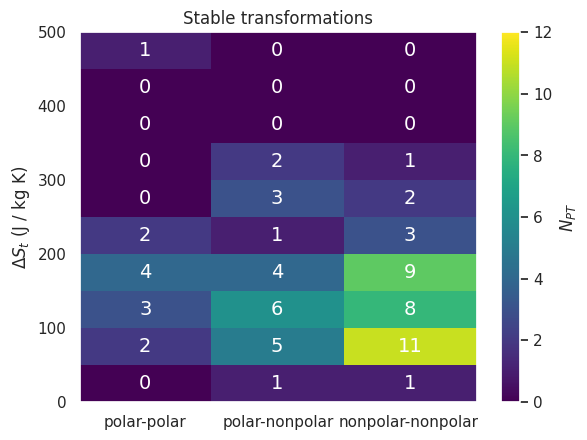

In [41]:
x_edges = np.array(centrosymmetry_edges)
y_edges = np.linspace(0, 500, 10+1)

# Generate the 2D histogram data
distribution = np.histogram2d(stable_transition_phases_low_uncert['centrosymmetry'],
                              stable_transition_phases_low_uncert['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=12)
plt.xticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.ylabel(r'$\Delta S_t$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Stable transformations')
plt.savefig(f'{output_folder}/entropy_changes_vs_stable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()

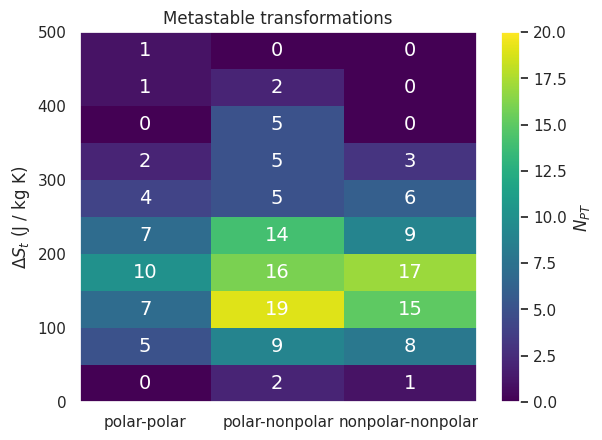

In [42]:
x_edges = np.array(centrosymmetry_edges)
y_edges = np.linspace(0, 500, 10+1)

# Generate the 2D histogram data
distribution = np.histogram2d(metastable_transition_phases_low_uncert['centrosymmetry'],
                              metastable_transition_phases_low_uncert['entropy-change'],
                              bins=(list(x_edges), list(y_edges))
                             )[0].T

# Create meshgrid for plotting
X, Y = np.meshgrid(x_edges, y_edges)

# Plot the 2D histogram with pcolormesh
fig, ax = plt.subplots()
plt.pcolormesh(X, Y, distribution, shading='auto', cmap='viridis', vmin=0, vmax=20)
plt.xticks(centrosymmetry_ticks_x,
           centrosymmetry_ticks_labels)
plt.ylabel(r'$\Delta S_t$ (J / kg K)')

# Calculate the centers of each cell
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers)

# Flatten the centers and Z values for vectorized annotation
x_flat = X_centers.flatten()
y_flat = Y_centers.flatten()
z_flat = distribution.flatten()

# Annotate all cells at once using vectorized operations
for xc, yc, z in zip(x_flat, y_flat, z_flat):
    ax.text(xc, yc, f'{int(z)}', ha='center', va='center', color='white', size=14)

# Add colorbar
colorbar = plt.colorbar()
colorbar.set_label(r'$N_{PT}$')

# Save the plot to a file
plt.title('Metastable transformations')
plt.savefig(f'{output_folder}/entropy_changes_vs_metastable_centrosymmetry.pdf', dpi=50, bbox_inches='tight')
plt.show()